In [ ]:
import requests
import json
import re
ALPACA_DATA_SECRET_KEY="w6mkp6JeLbLMp5AVMKtviFEyubggFJvkjgsVMApA"
ALPACA_DATA_PUBLIC_KEY="AKZS8A4U96H2NUFJRGCV"

def get_news(page_token=None):
  headers = {
      'Apca-Api-Key-Id': ALPACA_DATA_PUBLIC_KEY,
      'Apca-Api-Secret-Key': ALPACA_DATA_SECRET_KEY,
  }

  params = {
      "start": "2022-01-01",
      "end": "2023-01-01",
      "symbols": "MSFT",
      "include_content": "true",
      "exclude_contentless": "true",
  }
  if page_token is not None:
    params["page_token"] = page_token

  return requests.get('https://data.alpaca.markets/v1beta1/news', headers=headers, params=params)

def remove_links(content):
    # Pattern to identify HTML anchor tags
    pattern = re.compile(r'<a\s+[^>]*>(.*?)<\/a>', re.IGNORECASE)
    # Replace the identified patterns with an empty string
    cleaned_content = re.sub(pattern, '', content)
    return cleaned_content


def parse_alpaca_api(api_response):
    # Convert bytes to string and load it as JSON
    api_response = api_response.decode('utf-8')
    data = json.loads(api_response)

    # Extract news items
    news_items = data.get('news', [])

    # Prepare the list to hold formatted news
    formatted_news = []

    # Iterate over each news item and prepare the human-readable format
    for item in news_items:
        # Extract relevant details
        news_dict = {
            "timestamp": item.get('created_at', 'No timestamp provided'),
            "author": item.get('author', 'No author provided'),
            "headline": item.get('headline', 'No headline provided'),
            "content": item.get('content', 'No content provided').replace('\\u003c', '<').replace('\\u003e', '>').replace('\\u0026', '&').replace('\\u0027', '\'').replace('\\u0022', '\"').replace('\\r\\n', '\n').replace('\\/', '/'),
            "source": item.get('source', 'No source provided')
        }

        news_dict["content"] = remove_links(news_dict["content"])
        # Append the dictionary to the list
        formatted_news.append(news_dict)

    return formatted_news


In [ ]:
def get_all_news(news_list, start=True, page_token=None):
  if (not start):
    news = get_news(page_token=page_token).content
    api_response = news.decode('utf-8')
    data = json.loads(api_response)
    page_token = data["next_page_token"]
    news = parse_alpaca_api(news)
    news_list.extend(news)
    if page_token is None:
      return
    get_all_news(news_list, start=False, page_token=page_token)
  else:
    news = get_news().content
    api_response = news.decode('utf-8')
    data = json.loads(api_response)
    page_token = data["next_page_token"]
    news = parse_alpaca_api(news)
    news_list.extend(news)
    get_all_news(news_list, start=False, page_token=page_token)

In [ ]:
news_list = []
get_all_news(news_list)

In [ ]:
len(news_list)

1514

We don't have time to go through all 1514 articles and mark them as good for the stock or bad for the stock. Lets have a computer do it.


Data pulled from
https://www.kaggle.com/datasets/hoshi7/news-sentiment-dataset?resource=download

In [ ]:
import pandas as pd
sentiment_df = pd.read_csv("https://raw.githubusercontent.com/Cal-Poly-Quant-Club/data/main/Sentiment_dataset.csv")

In [ ]:
sentiment_df = sentiment_df.drop(["news_title", "reddit_title", "url"], axis=1)
# sentiment_df["sentiment"] = sentiment_df["sentiment"].map({1.0: 'positive', 0.0: 'negative'})
sentiment_df

,sentiment,text
0,1.0,Billionaire investor and Shark Tank star Mark ...
1,1.0,Attorney Jarrett Adams recently helped overtur...
2,1.0,The Amazon Rainforest is well known across the...
3,1.0,Newark police: No officer fired a single shot ...
4,1.0,I 1970 døde det 560 mennesker i den norske tra...
...,...,...
843,0.0,Frightening details have emerged about a toile...
844,0.0,"interview\n\nJohannesburg — 360,000 adolescent..."
845,0.0,A violent attack in the southern Israeli port ...
846,0.0,"It's a 17-year-old boy, too frightened to wear..."


In [ ]:
sentiment_df[sentiment_df["sentiment"] == 0].iloc[7]["text"]

'A growing quarrel between two men in the southern French town of Grasse has resulted in a drama for the 3-year-old child of one of them. When the little one started to cry because of the commotion, it was attacked by a Malinois dog and bitten no less than 56 times.\n\nThe facts happened on Sunday, according to the regional newspaper Nice-Matin. Some of the neighbors had then gathered for dinner, and there was heavy drinking.\n\nQuarrel\n\nAt some point, the host got into a misunderstanding with the child’s father and they even started to fight. The host’s dog – a Malinois Shepherd – intervened to defend his master and bit the father of the child, in his twenties.\n\nBecause of all the commotion, the bitten man’s child started to cry and the dog turned against him. The animal attacked and bit the child no less than 56 times over his entire body. The child was seriously injured and was taken to the hospital in Nice and appeared to be bitten in the arms and thighs.\n\nThe child’s father 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

texts = sentiment_df["text"].to_list()
labels = sentiment_df['sentiment'].values.astype(np.float32)

# Preparing text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=200)
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Building the LSTM model
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=200),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
# Training the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

848 848
848 848
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 64)           320000    
                                                                 
 lstm_6 (LSTM)               (None, 200, 64)           33024     
                                                                 
 dropout_6 (Dropout)         (None, 200, 64)           0         
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 365473 (1.39 MB)
Trainab

In [ ]:
# Function to predict sentiment of new articles
def predict_sentiment(articles):
    contents = [article['content'] for article in articles]
    sequences = tokenizer.texts_to_sequences(contents)
    padded_sequences = pad_sequences(sequences, maxlen=200)
    predictions = model.predict(padded_sequences)
    return [1 if pred > 0.5 else 0 for pred in predictions]

# Example usage
new_articles = [
    {"content": "I love this new movie, it was fantastic and exciting!"},
    {"content": "The movie was dull and I regret watching it."}
]

sentiments = predict_sentiment(new_articles)
print(sentiments)

1/1 [==============================] - 0s 85ms/step
[0, 0]


In [ ]:
sentiments = predict_sentiment(news_list)
sum(sentiments)/len(sentiments)

48/48 [==============================] - 3s 64ms/step


0.9986789960369881

In [ ]:
temp_df = pd.DataFrame(sentiments)
temp_df.columns = ["sentiment"]
temp_df

,sentiment
0,1
1,1
2,1
3,1
4,1
...,...
1509,1
1510,1
1511,1
1512,1


In [ ]:
temp_df["sentiment"].value_counts()

sentiment
1    1512
0       2
Name: count, dtype: int64

In [ ]:
news_sentiment_df = pd.DataFrame(news_list)
news_sentiment_df["sentiment"] = temp_df["sentiment"]
news_sentiment_df.index = news_sentiment_df["timestamp"]
news_sentiment_df = news_sentiment_df.drop(["timestamp"], axis=1)
news_sentiment_df.index = pd.to_datetime(news_sentiment_df.index).tz_localize(None)
news_sentiment_df

,author,headline,content,source,sentiment
timestamp,,,,,
2022-12-30 18:45:56,Lisa Levin,"Raytheon Technologies, Estée Lauder And This S...","<p>On CNBC&rsquo;s &quot;,&quot; <strong>Jim L...",benzinga,1
2022-12-30 16:05:36,Franca Quarneti,The 5 Most Viewed FPS Games On Twitch In 2022:...,"<p>With 15 million daily users, <strong>Amazon...",benzinga,1
2022-12-29 19:56:47,Adam Eckert,"Saperstein's Top Stocks For 2023: Microsoft, L...",<p>Treasury Partners&rsquo; <strong>Richard Sa...,benzinga,1
2022-12-29 18:06:28,Benzinga Insights,This Is What Whales Are Betting On Microsoft,<p>A whale with a lot of money to spend has ta...,benzinga,1
2022-12-29 12:11:03,Anusuya Lahiri,Alibaba Chief Takes Charge Of Alibaba Cloud Fo...,<ul>\r\n\t<li><strong>Alibaba Group Holding Li...,benzinga,1
...,...,...,...,...,...
2022-01-04 17:42:32,Benzinga Insights,10 Information Technology Stocks Whale Activit...,<p>This whale alert can help traders discover ...,benzinga,1
2022-01-02 22:18:59,Chris Katje,Top 10 Most Searched Tickers On Benzinga Pro I...,<p>Many of Benzinga&rsquo;s centered on the w...,benzinga,1
2022-01-03 17:36:45,Benzinga Insights,10 Information Technology Stocks Whale Activit...,<p>This whale alert can help traders discover ...,,1


In [ ]:
import datetime as dt
stock_df = pd.read_csv('https://raw.githubusercontent.com/Cal-Poly-Quant-Club/data/main/stock_data.csv', header=[0, 1], index_col=0)["MSFT"]
stock_df.index = pd.to_datetime(stock_df.index).normalize().tz_localize(None)
start = dt.datetime(2022, 1, 1)
end = dt.datetime(2023, 1, 1)
msft_df = stock_df[start:end]
msft_df

,close,high,low,trades,open,volume,volume weighted
time,,,,,,,
2022-01-03,334.75,338.00,329.7800,395295,335.35,32126045,333.521591
2022-01-04,329.01,335.20,326.1200,517998,334.83,36352727,329.451903
2022-01-05,316.38,326.07,315.9800,640417,325.76,44127998,319.766883
2022-01-06,313.88,318.70,311.4900,628056,313.15,44158209,315.059377
2022-01-07,314.04,316.50,310.0900,499018,314.15,36145004,313.803578
...,...,...,...,...,...,...,...
2022-12-23,238.73,238.87,233.9428,257927,236.11,23203754,237.362706
2022-12-27,236.96,238.93,235.8300,226698,238.70,19162129,237.244167
2022-12-28,234.53,239.72,234.1700,215795,236.89,19858985,236.066167


In [ ]:
# Convert indices to date objects to align types
stock_df.index = pd.to_datetime(stock_df.index).normalize().date

# Sum sentiments by day
daily_sentiment = news_sentiment_df.resample('D').sum()['sentiment']
daily_sentiment.index = daily_sentiment.index.date  # Convert index to date to match msft_df index

# Ensure msft_df index is also date type for consistency
msft_df.index = pd.to_datetime(msft_df.index).date

# Merge using pandas merge, which can handle different types (but here we ensure both are date objects)
msft_df = pd.merge(msft_df, daily_sentiment, left_index=True, right_index=True, how='left', suffixes=('', '_sum'))
msft_df
# Replace NaN with 0 if there are any days without corresponding sentiment data
msft_df['sentiment_sum'] = msft_df['sentiment'].fillna(0)

# Print the result
msft_df


,close,high,low,trades,open,volume,volume weighted,sentiment,sentiment_sum
2022-01-03,334.75,338.00,329.7800,395295,335.35,32126045,333.521591,2,2
2022-01-04,329.01,335.20,326.1200,517998,334.83,36352727,329.451903,5,5
2022-01-05,316.38,326.07,315.9800,640417,325.76,44127998,319.766883,6,6
2022-01-06,313.88,318.70,311.4900,628056,313.15,44158209,315.059377,3,3
2022-01-07,314.04,316.50,310.0900,499018,314.15,36145004,313.803578,0,0
...,...,...,...,...,...,...,...,...,...
2022-12-23,238.73,238.87,233.9428,257927,236.11,23203754,237.362706,5,5
2022-12-27,236.96,238.93,235.8300,226698,238.70,19162129,237.244167,2,2
2022-12-28,234.53,239.72,234.1700,215795,236.89,19858985,236.066167,0,0
2022-12-29,241.01,241.92,235.6500,224835,235.65,22955547,240.247168,5,5


Epoch 1/60
164/164 - 3s - loss: 0.1096 - 3s/epoch - 18ms/step
Epoch 2/60
164/164 - 0s - loss: 0.0096 - 302ms/epoch - 2ms/step
Epoch 3/60
164/164 - 0s - loss: 0.0069 - 286ms/epoch - 2ms/step
Epoch 4/60
164/164 - 0s - loss: 0.0061 - 283ms/epoch - 2ms/step
Epoch 5/60
164/164 - 0s - loss: 0.0052 - 299ms/epoch - 2ms/step
Epoch 6/60
164/164 - 0s - loss: 0.0047 - 285ms/epoch - 2ms/step
Epoch 7/60
164/164 - 0s - loss: 0.0042 - 278ms/epoch - 2ms/step
Epoch 8/60
164/164 - 0s - loss: 0.0037 - 277ms/epoch - 2ms/step
Epoch 9/60
164/164 - 0s - loss: 0.0035 - 283ms/epoch - 2ms/step
Epoch 10/60
164/164 - 0s - loss: 0.0032 - 279ms/epoch - 2ms/step
Epoch 11/60
164/164 - 0s - loss: 0.0032 - 397ms/epoch - 2ms/step
Epoch 12/60
164/164 - 0s - loss: 0.0031 - 372ms/epoch - 2ms/step
Epoch 13/60
164/164 - 0s - loss: 0.0030 - 368ms/epoch - 2ms/step
Epoch 14/60
164/164 - 0s - loss: 0.0029 - 398ms/epoch - 2ms/step
Epoch 15/60
164/164 - 0s - loss: 0.0030 - 420ms/epoch - 3ms/step
Epoch 16/60
164/164 - 0s - loss: 0.0

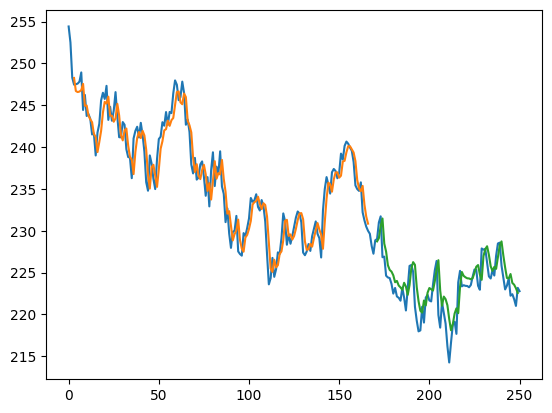

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

def normalize_dataset(dataset):
  scaler = MinMaxScaler(feature_range=(0, 1))
  normalized_dataset = scaler.fit_transform(dataset)
  return normalized_dataset

def test_train_split(normalized_dataset, test_perc):
  # split into train and test sets
  train_size = int(len(normalized_dataset) * test_perc)
  test_size = len(normalized_dataset) - train_size
  train, test = normalized_dataset[0:train_size,:], normalized_dataset[train_size:len(normalized_dataset),:]
  return train, test

def create_train_test(train, test, look_back=1):
  trainX, trainY = create_dataset(train, look_back)
  testX, testY = create_dataset(test, look_back)
  return trainX, testX, trainY, testY

def reshape_train_test(trainX, testX):
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
  return trainX, testX

def get_train_test_from_data(dataset, look_back=1, test_perc=0.67):
  normalized_dataset = normalize_dataset(dataset)
  train, test = test_train_split(normalized_dataset, test_perc)
  trainX, testX, trainY, testY = create_train_test(train, test, look_back)
  trainX, testX = reshape_train_test(trainX, testX)
  return trainX, testX, trainY, testY

def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
  a = dataset[i:(i+look_back), 0]
  dataX.append(a)
  dataY.append(dataset[i + look_back, 0])
 return np.array(dataX), np.array(dataY)


def evaluate(model, trainX, testX, trainY, testY):
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # Assuming only the first column (close prices) need to be inversely transformed:
    # Reshape predictions to match the scaler's expected input
    trainPredict_reshaped = np.zeros((len(trainPredict), 2))  # create a dummy array with two columns
    trainPredict_reshaped[:, 0] = trainPredict[:, 0]  # place trainPredict in the first column
    testPredict_reshaped = np.zeros((len(testPredict), 2))  # create a dummy array with two columns
    testPredict_reshaped[:, 0] = testPredict[:, 0]  # place testPredict in the first column

    # inverse transform the reshaped predictions
    trainPredict = scaler.inverse_transform(trainPredict_reshaped)[:, 0]
    testPredict = scaler.inverse_transform(testPredict_reshaped)[:, 0]

    # inverse transform the actual Y values
    trainY = scaler.inverse_transform(np.column_stack((trainY, np.zeros_like(trainY))))[:, 0]
    testY = scaler.inverse_transform(np.column_stack((testY, np.zeros_like(testY))))[:, 0]

    # calculate root mean squared error
    trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
    testScore = np.sqrt(mean_squared_error(testY, testPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    print('Test Score: %.2f RMSE' % (testScore))

    return trainPredict, testPredict

def plot_results(model, dataset, trainPredict, testPredict):
  normalized_dataset = normalize_dataset(dataset)

  # Initialize arrays with NaNs
  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(normalized_dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(trainPredict)+look_back, 0] = trainPredict  # Adjusted to use 1D indexing

  # shift test predictions for plotting
  testPredictPlot = np.empty_like(normalized_dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+(look_back*2)+1:len(normalized_dataset)-1, 0] = testPredict  # Adjusted to use 1D indexing

  # plot baseline and predictions
  plt.plot(scaler.inverse_transform(normalized_dataset)[:, 0])  # Ensure to plot the first column
  plt.plot(trainPredictPlot[:, 0])
  plt.plot(testPredictPlot[:, 0])
  plt.show()




# Parse dataset
dataset = msft_df[["close","sentiment"]].values
dataset = dataset.astype('float32')
look_back = 3
test_perc = 0.67
scaler = MinMaxScaler(feature_range=(0, 3))
normalized_dataset = scaler.fit_transform(dataset)

# Get train/test data
trainX, testX, trainY, testY = get_train_test_from_data(dataset, look_back, test_perc)
# Create the model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# Train the model
model.fit(trainX, trainY, epochs=60, batch_size=1, verbose=2)
# See how the model did & generate predictions
trainPredict, testPredict = evaluate(model, trainX, testX, trainY, testY)
# Plot predictions against reality
plot_results(model, dataset, trainPredict, testPredict)

3/3 [==============================] - 0s 4ms/step
Train Score: 1.99 RMSE
Test Score: 2.24 RMSE
[[334.75]
 [329.01]
 [316.38]
 [313.88]
 [314.04]
 [314.27]
 [314.98]
 [318.27]
 [304.8 ]
 [310.2 ]
 [302.65]
 [303.33]
 [301.6 ]
 [296.03]
 [296.37]
 [288.49]
 [296.71]
 [299.84]
 [308.26]
 [310.98]
 [308.76]
 [313.46]
 [301.25]
 [305.94]
 [300.95]
 [304.56]
 [311.21]
 [302.38]
 [295.04]
 [295.  ]
 [300.47]
 [299.5 ]
 [290.73]
 [287.93]
 [287.72]
 [280.34]
 [294.59]
 [297.31]
 [298.79]
 [294.95]
 [300.19]
 [295.92]
 [289.86]
 [278.91]
 [275.85]
 [288.5 ]
 [285.59]
 [280.07]
 [276.44]
 [287.15]
 [294.39]
 [295.22]
 [300.43]
 [299.16]
 [304.06]
 [299.49]
 [304.1 ]
 [303.68]
 [310.7 ]
 [315.41]
 [313.86]
 [308.31]
 [309.42]
 [314.97]
 [310.88]
 [299.5 ]
 [301.37]
 [296.97]
 [285.26]
 [282.06]
 [287.62]
 [279.83]
 [280.52]
 [285.3 ]
 [286.36]
 [280.81]
 [274.03]
 [280.72]
 [270.22]
 [283.22]
 [289.63]
 [277.52]
 [284.47]
 [281.78]
 [289.98]
 [277.35]
 [274.73]
 [264.58]
 [269.5 ]
 [260.55]
 [25

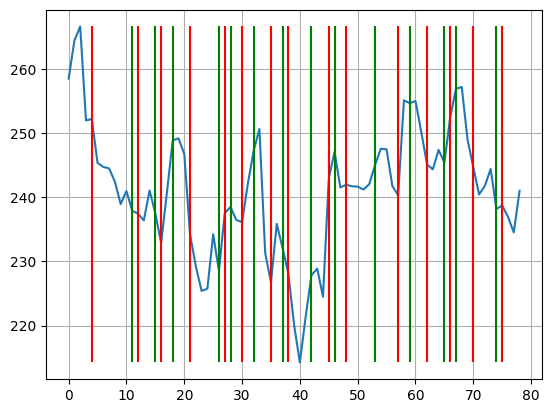

In [ ]:


trainPredict, testPredict = evaluate(model, trainX, testX, trainY, testY)

difference = testPredict - np.roll(testPredict, 1)
# Calculate the signs of elements
signs = np.sign(difference)
# print(signs)
# Find where the sign changes (from -1 to 1 or 1 to -1)
change_points = np.diff(signs, axis=0)

decision_matrix = np.zeros_like(difference)
# Assign 1 to the position after change from negative to positive
decision_matrix[np.where(change_points == 2)[0] + 1] = 1

# Assign -1 to the position after change from positive to negative
decision_matrix[np.where(change_points == -2)[0] + 1] = -1
# print(decision_matrix)
just_values = dataset[:, 0].reshape(1, 251).T
print(just_values)
aligned_dataset = just_values[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :]
profit = np.dot(decision_matrix.T, aligned_dataset)
print(profit)
print(aligned_dataset[-1] - aligned_dataset[0])
plt.plot(aligned_dataset)

for idx in range(len(decision_matrix)):
    if decision_matrix[idx] == 1:
        plt.vlines(idx, colors='green', ymin=min(aligned_dataset), ymax=max(aligned_dataset))
    elif decision_matrix[idx] == -1:
        plt.vlines(idx, colors='red', ymin=min(aligned_dataset), ymax=max(aligned_dataset))

plt.grid(True)
plt.show()